In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime as dt
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
data_path = r'../data/clean_df.csv.gz'
df = pd.read_csv(data_path).drop('Unnamed: 0', axis=1)
df.head()

,Unnamed: 0.1,Unnamed: 0.1.1,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,...,DISTANCE FROM MADISON SQUARE GARDEN,DISTANCE FROM PORT AUTHORITY,DISTANCE FROM GRAND ARMY PLAZA,DISTANCE FROM TRIBECA,DISTANCE FROM BATTERY PARK,DISTANCE FROM SOHO,DISTANCE FROM CONEY ISLAND,DAYS FROM NEW YEARS,DAYS FROM CHRISTMAS,DAYS FROM JULY 4
0,0,0,2017-06-26 00:00:00,2020-12-01 22:00:00,MANHATTAN,10002.0,40.718270,-73.99072,POINT (-73.99072 40.71827),ALLEN ST,...,0.032134,0.038880,0.051023,0.017988,0.029482,0.013270,0.144167,176 days,-182 days,-8 days
1,1,1,2017-07-14 00:00:00,2020-12-01 13:17:00,MANHATTAN,10028.0,40.783180,-73.94362,POINT (-73.94362 40.78318),FDR DR,...,0.059596,0.054004,0.113396,0.093249,0.107943,0.084330,0.209438,194 days,-164 days,10 days
2,2,2,2017-07-04 00:00:00,2020-12-01 14:00:00,BRONX,10462.0,40.833557,-73.85774,POINT (-73.85774 40.833557),WESTCHESTER AVE,...,0.159107,0.153556,0.195316,0.191071,0.205098,0.182365,0.281697,184 days,-174 days,0 days
3,3,3,2017-07-17 00:00:00,2020-12-01 21:03:00,MANHATTAN,10032.0,40.833843,-73.94851,POINT (-73.94851 40.833843),RIVERSIDE DR,...,0.094805,0.087647,0.162559,0.132012,0.147135,0.123243,0.259294,197 days,-161 days,13 days
4,4,4,2017-06-26 00:00:00,2020-12-01 15:35:00,BROOKLYN,11203.0,40.654434,-73.92139,POINT (-73.92139 40.654434),REMSEN AVE,...,0.119852,0.124044,0.050176,0.106925,0.106393,0.106784,0.093070,176 days,-182 days,-8 days


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1382598 entries, 0 to 1382597
Data columns (total 56 columns):
 #   Column                               Non-Null Count    Dtype  
---  ------                               --------------    -----  
 0   Unnamed: 0.1                         1382598 non-null  int64  
 1   Unnamed: 0.1.1                       1382598 non-null  int64  
 2   CRASH DATE                           1382598 non-null  object 
 3   CRASH TIME                           1382598 non-null  object 
 4   BOROUGH                              1367112 non-null  object 
 5   ZIP CODE                             1382598 non-null  float64
 6   LATITUDE                             1382598 non-null  float64
 7   LONGITUDE                            1382598 non-null  float64
 8   LOCATION                             1382598 non-null  object 
 9   ON STREET NAME                       1122268 non-null  object 
 10  CROSS STREET NAME                    908183 non-null   object 
 11

In [4]:
df['CRASH TIME'] = pd.to_datetime(df['CRASH TIME'])
df['CRASH DATE'] = pd.to_datetime(df['CRASH DATE'])

<AxesSubplot:>

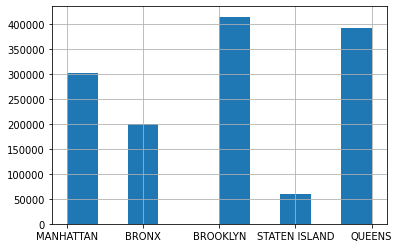

In [5]:
df['BOROUGH'].hist()

A lot more accidents in Brooklyn and Queens than in Manhattan. Unexpected. Let's examine each of those boroughs and determine if there are specific "danger areas."

In [6]:
brooklyn = df[df['BOROUGH'] == 'BROOKLYN']
brooklyn.loc[:,'ON STREET NAME'] = brooklyn['ON STREET NAME'].apply(lambda x: str(x).rstrip())

/home/yehuda/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [7]:
brooklyn.head()

,Unnamed: 0.1,Unnamed: 0.1.1,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,...,DISTANCE FROM MADISON SQUARE GARDEN,DISTANCE FROM PORT AUTHORITY,DISTANCE FROM GRAND ARMY PLAZA,DISTANCE FROM TRIBECA,DISTANCE FROM BATTERY PARK,DISTANCE FROM SOHO,DISTANCE FROM CONEY ISLAND,DAYS FROM NEW YEARS,DAYS FROM CHRISTMAS,DAYS FROM JULY 4
4,4,4,2017-06-26,2020-12-01 15:35:00,BROOKLYN,11203.0,40.654434,-73.92139,POINT (-73.92139 40.654434),REMSEN AVE,...,0.119852,0.124044,0.050176,0.106925,0.106393,0.106784,0.093070,176 days,-182 days,-8 days
8,8,8,2017-06-23,2020-12-01 13:30:00,BROOKLYN,11203.0,40.651420,-73.93716,POINT (-73.93716 40.65142),EAST 43 ST,...,0.113716,0.118619,0.037518,0.096504,0.094269,0.097476,0.082999,173 days,-185 days,-11 days
11,11,11,2017-07-06,2020-12-01 14:30:00,BROOKLYN,11206.0,40.709015,-73.94855,POINT (-73.94855 40.709015),LORIMER ST,...,0.060902,0.064136,0.041486,0.060490,0.067709,0.056293,0.135340,186 days,-172 days,2 days
13,13,13,2017-06-24,2020-12-01 00:30:00,BROOKLYN,11201.0,40.686080,-73.99091,POINT (-73.99091 40.68608),SMITH ST,...,0.064263,0.071069,0.026463,0.035017,0.030318,0.039134,0.112412,174 days,-184 days,-10 days
14,14,14,2017-07-02,2020-12-01 20:03:00,BROOKLYN,11214.0,40.594444,-73.98602,POINT (-73.98602 40.594444),BENSON AVE,...,0.156025,0.162779,0.080045,0.123930,0.112716,0.129970,0.024363,182 days,-176 days,-2 days


##### Create a table that examines the number of accidents on a street, divided by the max Euclidean distance between the furthest accidents. You can do this by creating a Euclidean distance for each accident from (0,0) and taking the max for that column for each street name.

### Accidents pivot table

In [8]:
lat_range = brooklyn.groupby('ON STREET NAME')['LATITUDE'].max() - brooklyn.groupby(('ON STREET NAME'))['LATITUDE'].min()
lon_range = brooklyn.groupby('ON STREET NAME')['LONGITUDE'].max() - brooklyn.groupby(('ON STREET NAME'))['LONGITUDE'].min()
euclidean_range = np.sqrt(lat_range ** 2 + lon_range ** 2)

In [9]:
brooklyn.loc[:,'RANGE'] = brooklyn['ON STREET NAME'].apply(lambda x: euclidean_range[x])

/home/yehuda/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/yehuda/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [10]:
euclidean_range_no_nans = euclidean_range[euclidean_range.index != 'nan']
euclidean_range_no_nans.sort_values(ascending=False)

ON STREET NAME
ATLANTIC AVE      0.426900
3 AVE             0.331295
60 ST             0.290725
FLATBUSH AVE      0.277066
PROSPECT EXPWY    0.264912
                    ...   
BEEKMAN PLACE     0.000000
MORTON ST         0.000000
FDR DR            0.000000
SOUTH FIRST ST    0.000000
KNIGHT COURT      0.000000
Length: 1791, dtype: float64

In [11]:
casualties = brooklyn.groupby('ON STREET NAME')['TOTAL PEDESTRIAN CASUALTIES'].sum()
casualties_no_nans = casualties[casualties.index != 'nan']
casualties_no_nans.sort_values(ascending=False)

ON STREET NAME
BEDFORD AVE       691
FLATBUSH AVE      654
ATLANTIC AVE      653
NOSTRAND AVE      649
FULTON ST         605
                 ... 
DOSHER ST           0
PAERDEGAT 3 ST      0
DORSET ST           0
PAERDEGAT 4 ST      0
HART PLACE          0
Name: TOTAL PEDESTRIAN CASUALTIES, Length: 1791, dtype: int64

In [12]:
euclidean_range.corr(casualties_no_nans)

0.5804362836884193

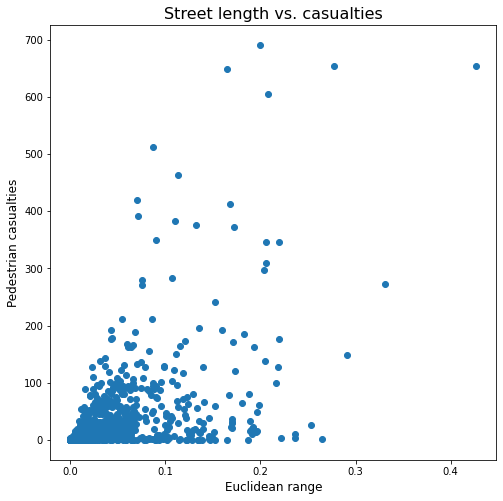

In [13]:
_ = plt.figure(figsize=(8,8))
_ = plt.scatter(euclidean_range_no_nans, casualties_no_nans)
_ = plt.xlabel('Euclidean range', fontsize=12)
_ = plt.ylabel('Pedestrian casualties', fontsize=12)
_ = plt.title('Street length vs. casualties', fontsize=16)

The pedestrian casualty count does not completely correlate to the Euclidean length of the street. For example, the highest pedestrian casualty count is on Bedford Ave, but the longest street by Euclidean measurement is Atlantic Ave.

In [14]:
street_count = brooklyn.groupby('ON STREET NAME')['COLLISION_ID'].count()
street_count

ON STREET NAME
1 AVE            148
1 COURT            5
1 PLACE           45
1 ST              73
10 AVE           452
               ...  
WYONA ST         128
WYTHE AVE        676
WYTHE PLACE        9
YORK ST           96
nan            79545
Name: COLLISION_ID, Length: 1792, dtype: int64

In [15]:
streets = pd.DataFrame({'# ACCIDENTS':street_count, 'MAP RANGE':euclidean_range, 'CASUALTIES':casualties},
                              index=euclidean_range.index)
streets.sort_values('CASUALTIES', ascending=False).head(10)

,# ACCIDENTS,MAP RANGE,CASUALTIES
ON STREET NAME,,,
nan,79545,0.590046,4551
BEDFORD AVE,4396,0.199750,691
FLATBUSH AVE,6976,0.277066,654
ATLANTIC AVE,10642,0.426900,653
NOSTRAND AVE,4710,0.164418,649
FULTON ST,3657,0.208204,605
5 AVE,2073,0.086465,512
BRDWAY,2448,0.113520,463
UTICA AVE,4032,0.069808,420


In [16]:
streets = streets.drop(streets.sort_values('CASUALTIES', ascending=False).index[0], axis=0)
streets.sort_values('CASUALTIES', ascending=False).head(10)

,# ACCIDENTS,MAP RANGE,CASUALTIES
ON STREET NAME,,,
BEDFORD AVE,4396,0.199750,691
FLATBUSH AVE,6976,0.277066,654
ATLANTIC AVE,10642,0.426900,653
NOSTRAND AVE,4710,0.164418,649
FULTON ST,3657,0.208204,605
5 AVE,2073,0.086465,512
BRDWAY,2448,0.113520,463
UTICA AVE,4032,0.069808,420
OCEAN AVE,2782,0.168181,412


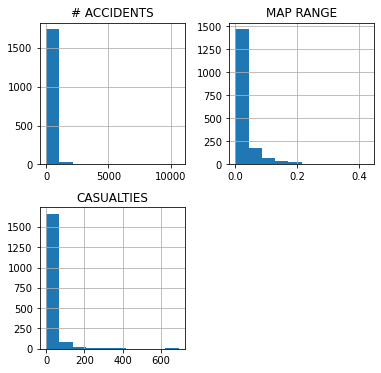

In [17]:
_ = streets.hist(figsize=(6,6))

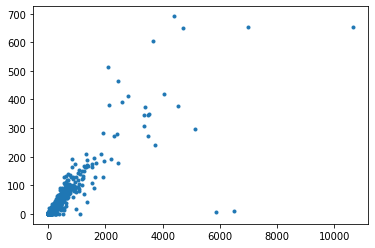

In [18]:
_ = plt.plot(streets['# ACCIDENTS'], streets['CASUALTIES'], marker='.', linestyle='none')

In [19]:
streets.corr()

,# ACCIDENTS,MAP RANGE,CASUALTIES
# ACCIDENTS,1.000000,0.630304,0.861726
MAP RANGE,0.630304,1.000000,0.580436
CASUALTIES,0.861726,0.580436,1.000000


Atlantic Ave is clearly an outlier with regard to number of accidents and number of casualties (since those are highly correlated, this is not a surprise). Is it related to the fact that the street is longer than most others?

In [20]:
map_head = streets.sort_values('MAP RANGE', ascending=False).head(50)
map_head.head()

,# ACCIDENTS,MAP RANGE,CASUALTIES
ON STREET NAME,,,
ATLANTIC AVE,10642,0.426900,653
3 AVE,3502,0.331295,273
60 ST,1193,0.290725,149
FLATBUSH AVE,6976,0.277066,654
PROSPECT EXPWY,29,0.264912,1


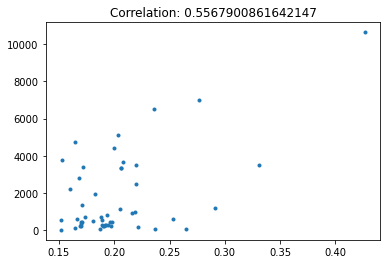

In [21]:
_ = plt.plot(map_head['MAP RANGE'], map_head['# ACCIDENTS'], marker='.', linestyle='none')
_ = plt.title('Correlation: {}'.format(map_head['MAP RANGE'].corr(map_head['# ACCIDENTS'])))

While a single accident may occur on a street, we are more interested in patterns. As such, we should consider dropping records where `# ACCIDENTS` equals 1.

In [22]:
len(streets[streets['# ACCIDENTS'] == 1])

211

In [23]:
more_accidents = streets[streets['# ACCIDENTS'] >= 10]
more_accidents.sort_values('# ACCIDENTS', ascending=True).head(10)

,# ACCIDENTS,MAP RANGE,CASUALTIES
ON STREET NAME,,,
NORTH ELLIOT PLACE,10,0.001738,3
CHASE COURT,10,0.002030,0
CHERRY ST,10,0.003115,0
SCHENCK ST,10,0.004164,1
SEABREEZE AVE,10,0.004210,1
CREAMER ST,10,0.010666,0
BRIGHTON 14 ST,10,0.002448,0
DE SALES PLACE,10,0.002012,2
SHERMAN ST,10,0.009318,1


In [24]:
more_accidents.corr()

,# ACCIDENTS,MAP RANGE,CASUALTIES
# ACCIDENTS,1.000000,0.625187,0.853412
MAP RANGE,0.625187,1.000000,0.566883
CASUALTIES,0.853412,0.566883,1.000000


##### Add daytime and weekend data to `more_accidents`

In [25]:
daytime_weekend = df.groupby('ON STREET NAME')[['WEEKEND', 'DURING DAYTIME']].sum()
dt_wk_streets = more_accidents.join(daytime_weekend, how='right')

In [26]:
dt_wk_streets.head()

,# ACCIDENTS,MAP RANGE,CASUALTIES,WEEKEND,DURING DAYTIME
ON STREET NAME,,,,,
1 AVE,148.0,0.090994,3.0,1220,3242
1 COURT,NaN,NaN,NaN,3,4
1 PLACE,45.0,0.005814,0.0,11,38
1 ST,73.0,0.022296,2.0,38,87
10 AVE,452.0,0.059985,54.0,1036,2792


Where are the accidents that don't have street labels? Maybe they're on major highways.

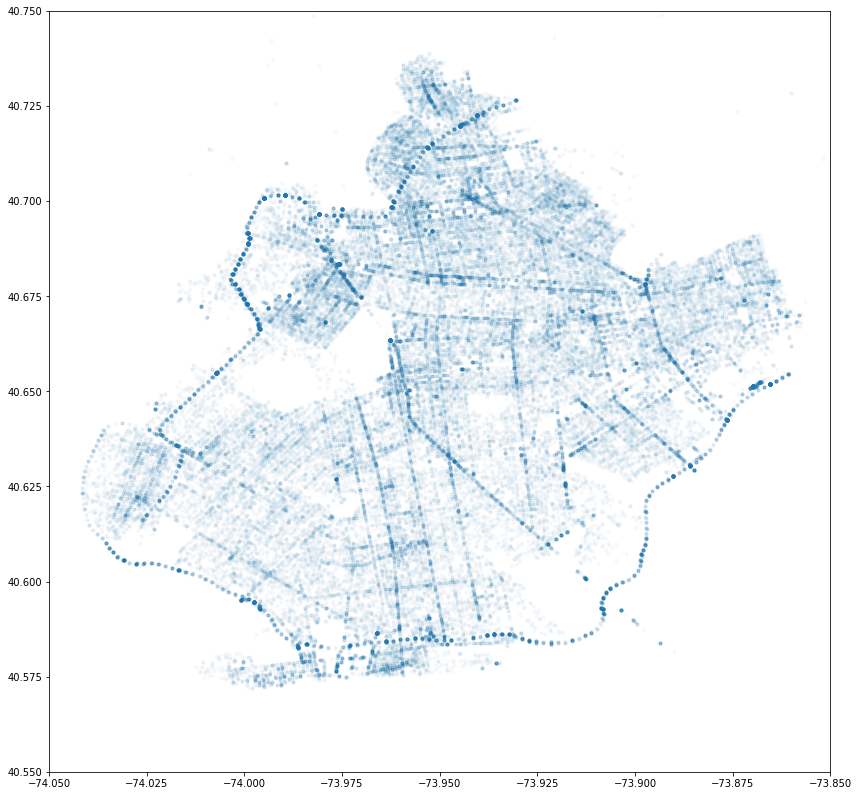

In [27]:
no_streets = df[(df['ON STREET NAME'].isnull() == True) & (df['BOROUGH'] == 'BROOKLYN')]

_ = plt.figure(figsize=(14,14))
_ = plt.plot(no_streets['LONGITUDE'], no_streets['LATITUDE'], marker='.', linestyle='none', alpha=0.03)
_ = plt.xlim(-74.05, -73.85)
_ = plt.ylim(40.55, 40.75)
plt.show()

### Hourly plots

##### Hourly data by borough

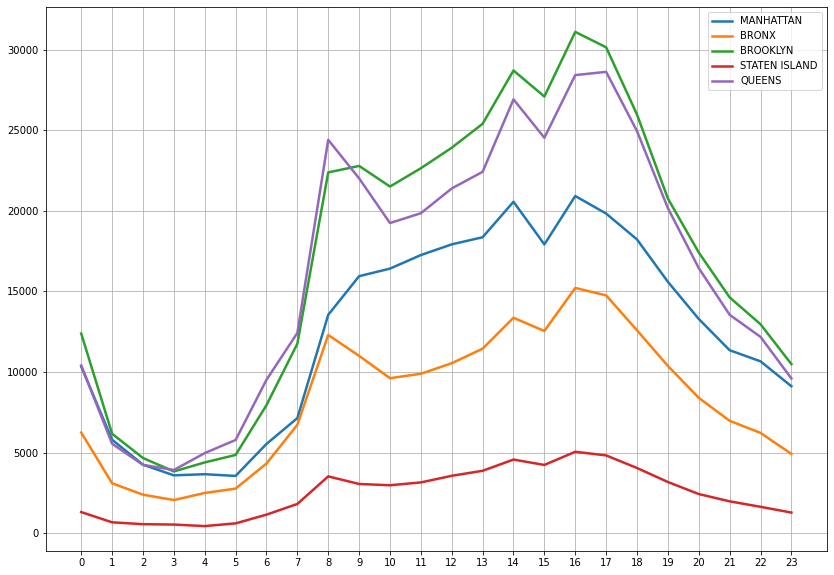

In [28]:
boroughs = df['BOROUGH'].dropna().unique()
plt.figure(figsize=(14,10))
for borough in boroughs:
    hours = df.loc[(df['BOROUGH'] == borough) == True].groupby(df['CRASH TIME'].dt.hour)\
    ['COLLISION_ID'].count()
    
    _ = plt.plot(range(0,24), hours, linestyle='-', linewidth=2.5)
    _ = plt.xticks(np.arange(0,24,1))
_ = plt.grid()
_ = plt.legend(boroughs)

1. Manhattan and the Bronx have a spike at 8 AM. Brooklyn hits that same high, but doesn't taper off afterwards. Manhattan doesn't spike at 8 AM at all.
2. All dip at 3 PM and spike at 4 PM then taper into the evenings.

##### Hourly data by day

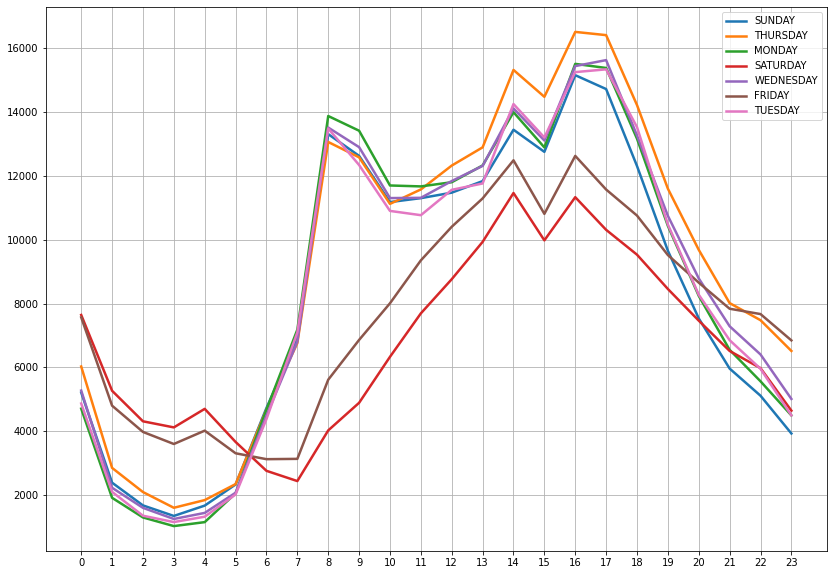

In [29]:
days = df['WEEKDAY'].unique()
plt.figure(figsize=(14,10))
for day in days:
    hours = df.loc[(df['WEEKDAY'] == day) == True].groupby(df['CRASH TIME'].dt.hour)\
    ['COLLISION_ID'].count()
    
    _ = plt.plot(range(0,24), hours, linestyle='-', linewidth=2.5)
    _ = plt.xticks(np.arange(0,24,1))
_ = plt.grid()
_ = plt.legend(days)
_ = plt.savefig(r'../Image resources/Weekdays.png')

1. Friday doesn't have an early morning spike.
2. There's always a dip at 3 PM.
3. The afternoon rush-hour spike is larger than the morning rush-hour spike.

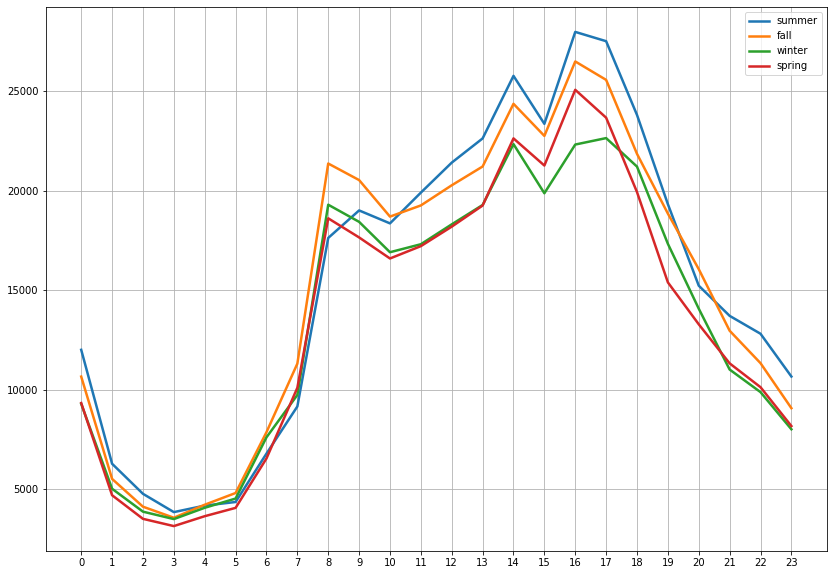

In [30]:
seasons = df['SEASON'].unique()
plt.figure(figsize=(14,10))
for season in seasons:
    hours = df.loc[(df['SEASON'] == season) == True].groupby(df['CRASH TIME'].dt.hour)\
    ['COLLISION_ID'].count()
    

    _ = plt.plot(range(0,24), hours, linestyle='-', linewidth=2.5)
    _ = plt.xticks(np.arange(0,24,1))
_ = plt.grid()
_ = plt.legend(seasons)

1. The data follows the same trend in each season.
2. There are more fall accidents than winter accidents in the morning.
3. There are the fewest summer accidents in the morning but the most in the evening.
4. Winter's accidents are second-highest in the morning but extemely low in the evening.

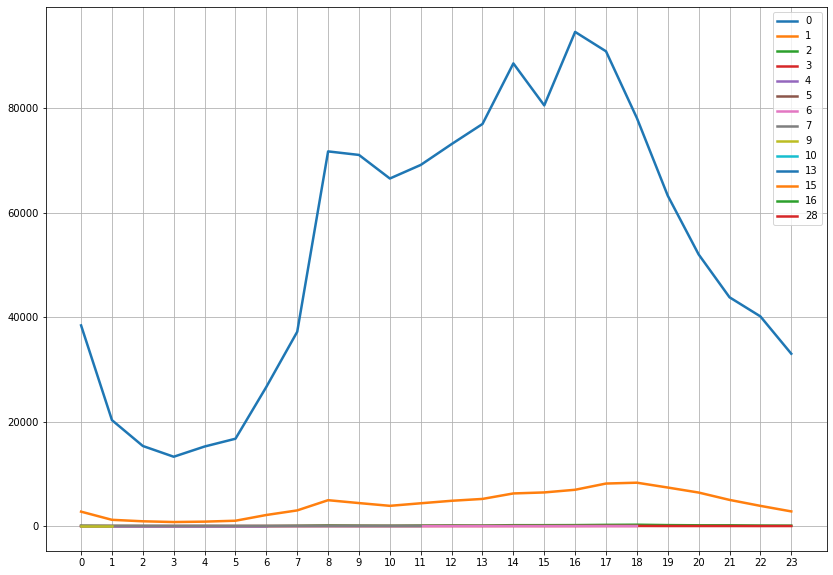

In [31]:
casualties = df['TOTAL PEDESTRIAN CASUALTIES'].unique()
plt.figure(figsize=(14,10))
for number in casualties:
    hours = df.loc[(df['TOTAL PEDESTRIAN CASUALTIES'] == number) == True].groupby(df['CRASH TIME'].dt.hour)\
    ['COLLISION_ID'].count()
    

    _ = plt.plot(range(0,len(hours)), hours, linestyle='-', linewidth=2.5)
    _ = plt.xticks(np.arange(0,24,1))
#     _ = plt.ylim(0,4500)
_ = plt.grid()
_ = plt.legend(np.sort(casualties))

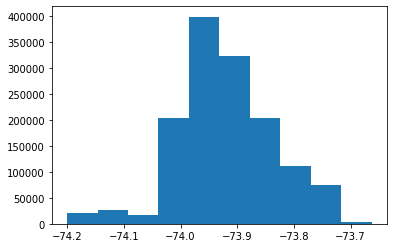

In [32]:
_ = plt.hist(df['LONGITUDE'])

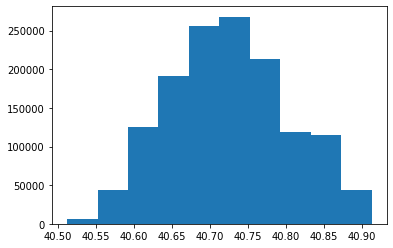

In [33]:
_ = plt.hist(df['LATITUDE'])

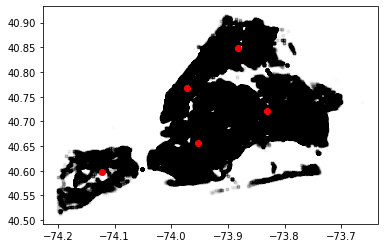

In [34]:
boroughs = ['MANHATTAN','BRONX','BROOKLYN','STATEN ISLAND','QUEENS']
_ = plt.plot(df['LONGITUDE'], df['LATITUDE'], 'k.', alpha=0.01)
for borough in boroughs:
    df_borough = df[df['BOROUGH'] == borough]
    _ = plt.plot(df_borough['LONGITUDE'].mean(), df_borough['LATITUDE'].mean(), 'or')

In [35]:
for borough in boroughs:
    df_borough = df['BOROUGH'] == borough
    borough_lat_mean = df.loc[df_borough,'LATITUDE'].mean()
    borough_lon_mean = df.loc[df_borough,'LONGITUDE'].mean()
    lon_distance = (df.loc[df_borough,'LONGITUDE'] - borough_lon_mean) ** 2
    lat_distance = (df.loc[df_borough,'LATITUDE'] - borough_lat_mean) ** 2
    df.loc[df_borough,'DISTANCE FROM MEAN'] = np.sqrt(lon_distance + lat_distance)

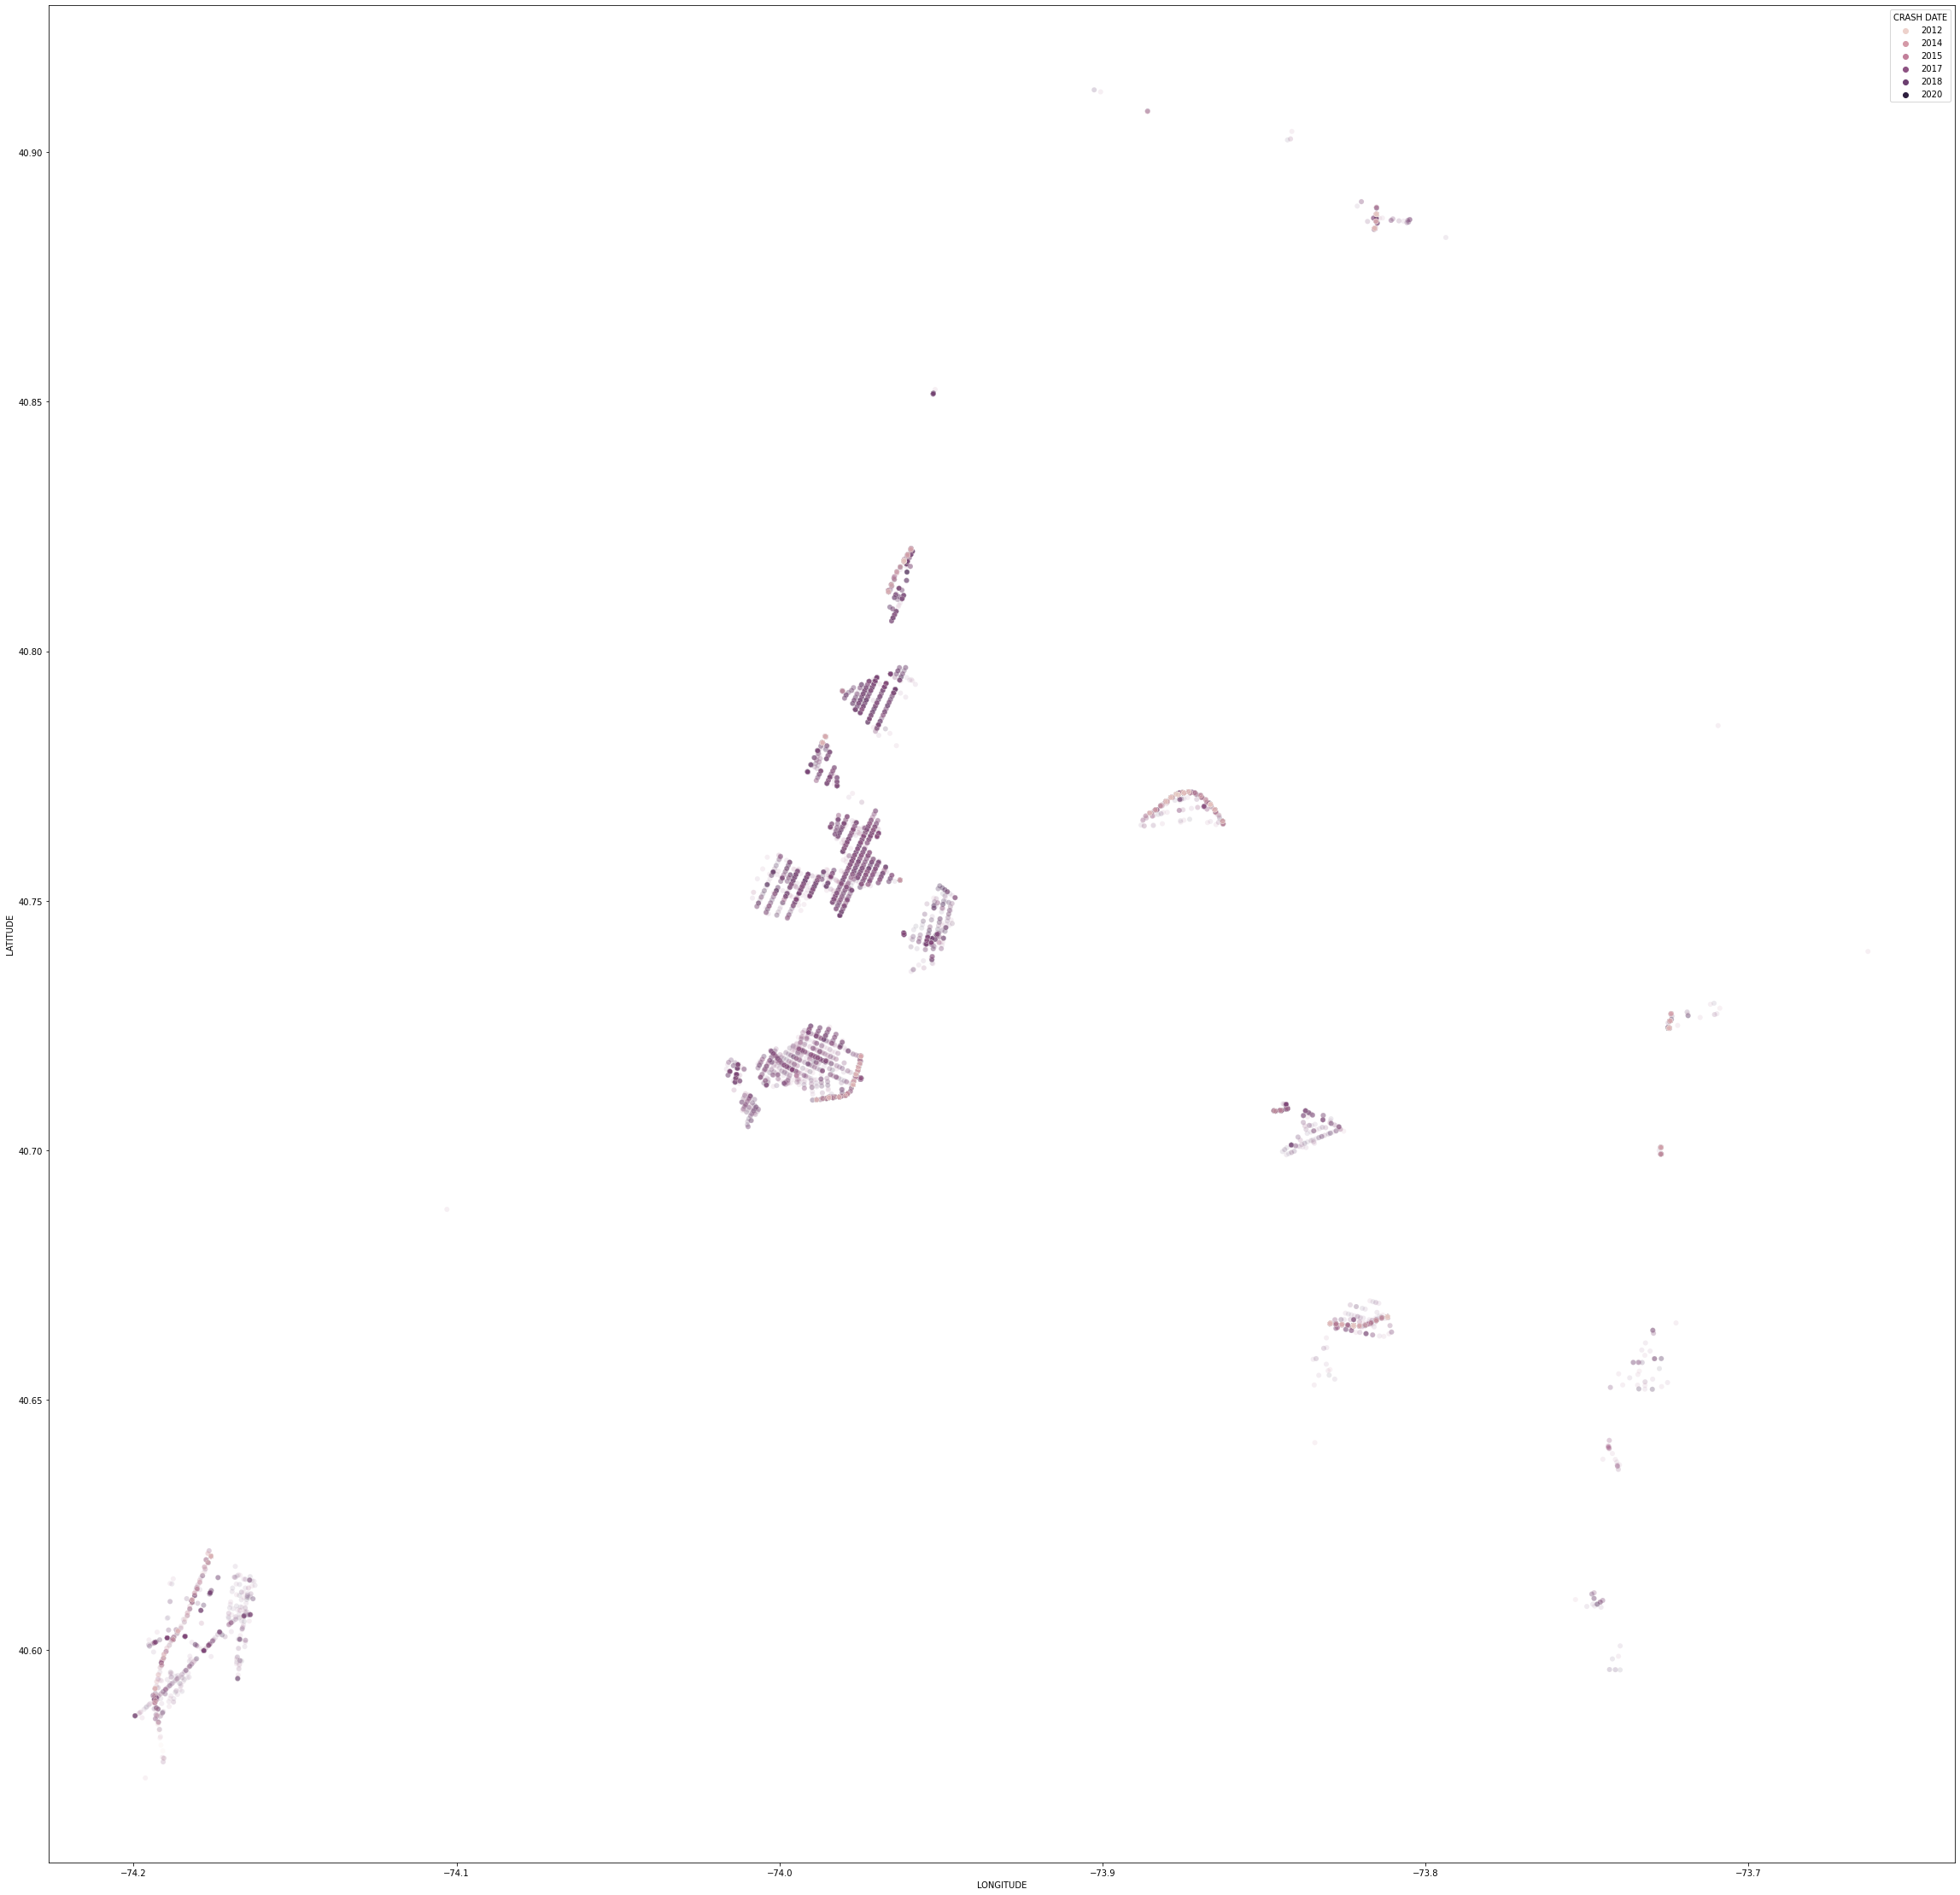

In [36]:
no_borough = df[df['BOROUGH'].isnull() == True]
_ = plt.figure(figsize=(40,40))
_ = sns.scatterplot(x='LONGITUDE',
                    y='LATITUDE',
                    data=no_borough,
                    hue=no_borough['CRASH DATE'].dt.year,
                    cmap='hus1',
                    alpha=0.1)

Null data seems to focus on the borders and through-streets. Are those highways?

In [37]:
no_borough['ON STREET NAME'].value_counts()[lambda x:x>1000]

Series([], Name: ON STREET NAME, dtype: int64)

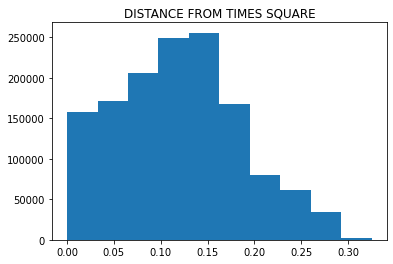

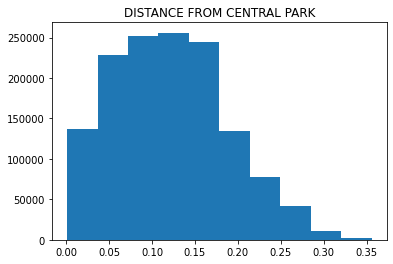

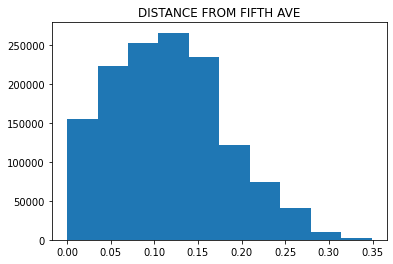

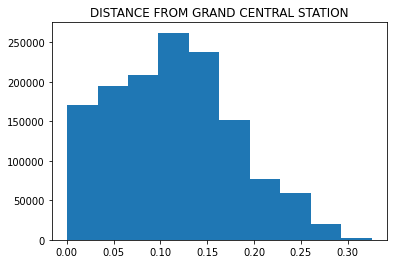

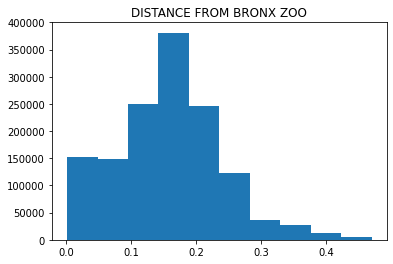

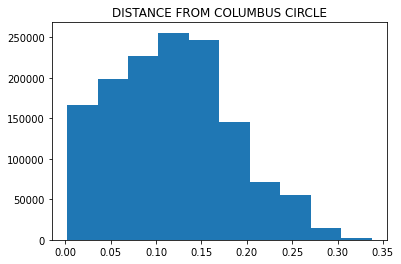

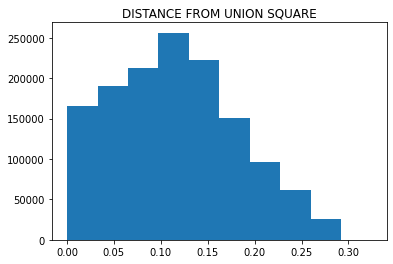

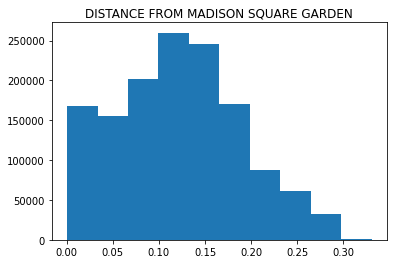

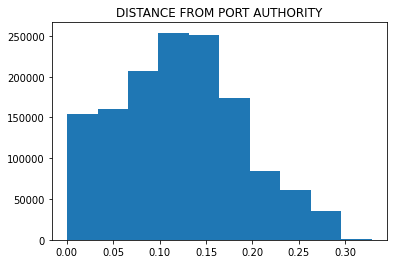

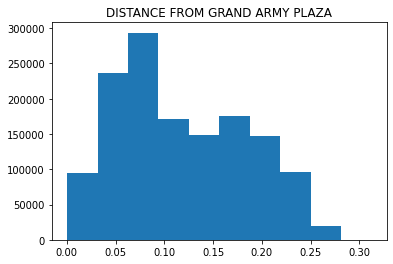

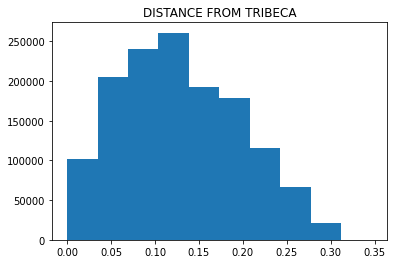

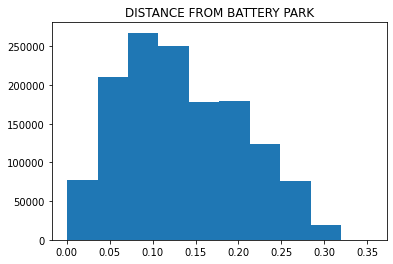

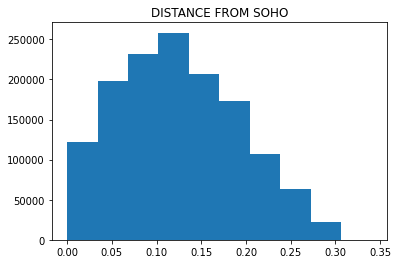

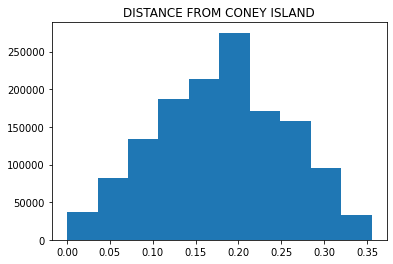

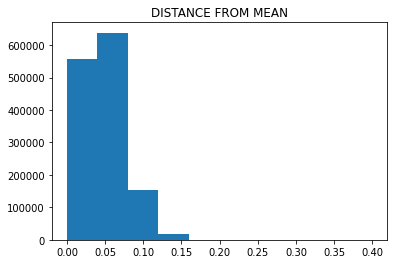

In [38]:
geo_features = [name for name in df.columns if 'DISTANCE FROM' in name]
for feature in geo_features:
    plt.hist(df[feature])
    plt.title(feature)
    plt.show()

I don't know why, but all the distances have different shapes. That seems very strange. Particularly odd is the `DISTANCE FROM CONEY ISLAND`, which has a normal (rather than Poisson) distribution, and `DISTANCE FROM BRONX ZOO`, which has a spike at around 0.16. Notably, these are the two geo features whose distances are outside Manhattan. This may contribute to the unusual spike.

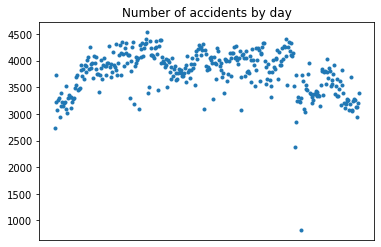

In [39]:
top_counts = df.groupby('DAYS FROM NEW YEARS')['DAYS FROM NEW YEARS'].count()
_ = plt.scatter(top_counts.index, top_counts, marker='.')
_ = plt.title('Number of accidents by day')
_ = plt.tick_params(
    axis='x',          
    which='both',      
    bottom=False,   
    top=False,         
    labelbottom=False) 
_ = plt.show()

In [40]:
top_counts[top_counts < 3000]

DAYS FROM NEW YEARS
0 days      2736
103 days    2948
358 days    2371
359 days    2839
365 days     822
96 days     2942
Name: DAYS FROM NEW YEARS, dtype: int64

In [41]:
top_counts.describe()

count     366.000000
mean     3777.590164
std       402.744157
min       822.000000
25%      3532.250000
50%      3849.000000
75%      4062.000000
max      4533.000000
Name: DAYS FROM NEW YEARS, dtype: float64

There is a particular dip around Christmas and New Years. This is to be expected. It is surprising that New Years is relatively so high.

In [42]:
with pd.option_context('display.max_rows', None):
    print(df['CONTRIBUTING FACTOR VEHICLE 1'].value_counts().sort_values(ascending=False))

Unspecified                                              533262
Driver Inattention/Distraction                           286915
Failure to Yield Right-of-Way                             87915
Following Too Closely                                     74909
Backing Unsafely                                          58683
Other Vehicular                                           47237
Passing or Lane Usage Improper                            37183
Turning Improperly                                        36381
Passing Too Closely                                       35286
Unsafe Lane Changing                                      28539
Traffic Control Disregarded                               22899
Driver Inexperience                                       22196
Alcohol Involvement                                       14387
Unsafe Speed                                              13779
Reaction to Uninvolved Vehicle                            13322
Prescription Medication                 

It may be worth combining these into a much more limited set of features, e.g. _distracted driver, DUI,_ etc.

### Term distribution

We are count-vectorizing `ON STREET NAME` and `CROSS STREET NAME`. However, a problem arises: When writing down street names, a shorthand is often used, such as "St" for "Street." This will cause a significant amount of confusion in the model. We must determine if this is occurring, and if so, is it on a significant scale.

In [70]:
df['ON STREET NAME'].fillna('', inplace=True)
count = CountVectorizer(min_df=30, max_df=0.9)
count_vec = count.fit_transform(df['ON STREET NAME'])
count_df = pd.DataFrame.sparse.from_spmatrix(count_vec)

In [71]:
alt_terms = [['st','street'],
             ['ave','avenue'],
             ['blvd','boulevard'],
             ['rd','road'],
             ['dr','drive'],
             ['crescent','cresc'],
             ['place','pl'],
             ['court','ct'],
             ['terrace','ter'],
             ['highway','hwy'],
             ['parkway','pkwy'],
             ['expressway','expwy'],
             ['junction','jct'],
             ['lane','ln'],
             ['square','sqr'],
             ['extension','ext'],
             ['freeway','frwy'],
             ['plaza','plz'],
             ['tunnel','tunl'],
             ['turnpike','tpke']
            ]
for term in alt_terms:
    try:
        print(term[0], count.vocabulary_[term[0]],
             term[1], count.vocabulary_[term[1]])
    except KeyError:
        continue

It appears to be a major issue. We will have to clean this.

In [78]:
alt_terms = ['STREET',
             'AVENUE',
             'BOULEVARD',
             'ROAD',
             'DRIVE',
             'PARKWAY',
             'EXPRESSWAY'
            ]
clean_terms = ['ST',
               'AVE',
               'BLVD',
               'RD',
               'DR',
               'PKWY',
               'EXPWY'
              ]
def alt_terms_clean(string):
    for alt, clean in zip(alt_terms, clean_terms):
        string = string.strip().replace(alt, clean)
    return string

df['ON STREET NAME'] = df['ON STREET NAME'].map(alt_terms_clean)

In [77]:
%%time`it
df['ON STREET NAME'].map(alt_terms_clean)

1.59 s ± 23.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [79]:
%%timeit
df['ON STREET NAME'].map(alt_terms_clean)

1.09 s ± 6.24 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [82]:
df['CROSS STREET NAME'].fillna('', inplace=True)
df['CROSS STREET NAME'].map(alt_terms_clean)

0             BROOME ST
1                      
2           PUGSLEY AVE
3           WEST 155 ST
4           LINDEN BLVD
               ...     
1382593    CLARENDON RD
1382594    SUTPHIN BLVD
1382595         104 AVE
1382596    CATHERINE ST
1382597          32 AVE
Name: CROSS STREET NAME, Length: 1382598, dtype: object